In [9]:
# 1. import packages and classes

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata, interp1d
from geoalchemy2.shape import to_shape

from app.db.database import get_session
from app.db.models import (
    HourlyActual, NoonForecast, PredictionModelGridSubset, ModelRunGridSubsetPrediction, PredictionModelRunTimestamp)
from sqlalchemy import extract

In [10]:
# 2. provide data

session = get_session()

PENTICTON = 328
PENTICTON_LAT = 49.5183333
PENTICTON_LONG = -119.5533333

STATION_CODE = PENTICTON
STATION_LONGITUDE = PENTICTON_LONG
STATION_LATITUDE = PENTICTON_LAT


In [11]:
# 2.1 actuals

# get the actuals, at noon (that's 20h00 utc)
actuals_query = session.query(HourlyActual)\
    .filter(HourlyActual.station_code==STATION_CODE)\
    .filter(extract('hour', HourlyActual.weather_date) == 20)\
    .filter(HourlyActual.temp_valid == True)

print("ACTUALS")
for actual in actuals_query:
    print('{actual.weather_date} {actual.temperature}'.format(actual=actual))
actual_x = [actual.weather_date for actual in actuals_query]
actual_y = [actual.temperature for actual in actuals_query]


ACTUALS
2020-09-02 20:00:00+00:00 24.1
2020-09-03 20:00:00+00:00 24.9
2020-09-04 20:00:00+00:00 24.6
2020-09-05 20:00:00+00:00 29.3
2020-09-06 20:00:00+00:00 28.4
2020-09-07 20:00:00+00:00 22.3
2020-09-08 20:00:00+00:00 20.3
2020-09-09 20:00:00+00:00 21.1
2020-09-11 20:00:00+00:00 25.6
2020-08-01 20:00:00+00:00 30.6
2020-08-02 20:00:00+00:00 31.0
2020-08-03 20:00:00+00:00 28.4
2020-08-04 20:00:00+00:00 27.2
2020-08-05 20:00:00+00:00 31.7
2020-08-06 20:00:00+00:00 23.6
2020-08-07 20:00:00+00:00 22.6
2020-08-08 20:00:00+00:00 23.8
2020-08-09 20:00:00+00:00 24.3
2020-08-10 20:00:00+00:00 26.0
2020-08-11 20:00:00+00:00 27.5
2020-08-12 20:00:00+00:00 22.5
2020-08-13 20:00:00+00:00 22.5
2020-08-14 20:00:00+00:00 25.5
2020-08-15 20:00:00+00:00 27.1
2020-08-16 20:00:00+00:00 28.8
2020-08-17 20:00:00+00:00 34.8
2020-08-18 20:00:00+00:00 33.8
2020-08-19 20:00:00+00:00 30.5
2020-08-20 20:00:00+00:00 25.4
2020-08-21 20:00:00+00:00 28.7
2020-08-22 20:00:00+00:00 25.0
2020-08-23 20:00:00+00:00 23.9


In [12]:
# 2.2 forecasts

# get the forecaster forecasts
forecast_query = session.query(NoonForecast)\
    .filter(NoonForecast.station_code==STATION_CODE)\
    .filter(NoonForecast.temp_valid==True)\
    .order_by(NoonForecast.weather_date, NoonForecast.created_at)

print("FORECASTS:")
# for forecast in forecast_query:
#     print('{forecast.weather_date} {forecast.temperature} ({forecast.created_at})'.format(forecast=forecast))


forecast_x = []
forecast_y = []
for forecast in forecast_query:
    if len(forecast_x) > 0 and forecast.weather_date in forecast_x:
        forecast_y[-1] = forecast.temperature
    else:
        forecast_x.append(forecast.weather_date)
        forecast_y.append(forecast.temperature)
    
# forecast_x = [forecast.weather_date for forecast in forecast_query]
# forecast_y = [forecast.temperature for forecast in forecast_query]

print('only the most recent!')
for a, b in zip(forecast_x, forecast_y):
    print('{} {}'.format(a, b))


FORECASTS:
only the most recent!
2020-08-12 20:00:00+00:00 18.0
2020-08-13 20:00:00+00:00 25.0
2020-08-14 20:00:00+00:00 29.0
2020-08-15 20:00:00+00:00 32.0
2020-08-16 20:00:00+00:00 34.0
2020-08-19 20:00:00+00:00 33.0
2020-08-20 20:00:00+00:00 28.0
2020-08-21 20:00:00+00:00 24.0
2020-08-22 20:00:00+00:00 28.0
2020-08-23 20:00:00+00:00 25.0
2020-08-24 20:00:00+00:00 24.0
2020-08-25 20:00:00+00:00 25.0
2020-08-26 20:00:00+00:00 24.0
2020-08-27 20:00:00+00:00 23.0
2020-08-28 20:00:00+00:00 26.0
2020-08-29 20:00:00+00:00 21.0
2020-08-30 20:00:00+00:00 20.0
2020-08-31 20:00:00+00:00 23.0
2020-09-01 20:00:00+00:00 27.0
2020-09-02 20:00:00+00:00 23.0
2020-09-03 20:00:00+00:00 28.0
2020-09-04 20:00:00+00:00 28.0
2020-09-05 20:00:00+00:00 29.0
2020-09-06 20:00:00+00:00 28.0
2020-09-07 20:00:00+00:00 20.0
2020-09-08 20:00:00+00:00 25.0
2020-09-09 20:00:00+00:00 24.0
2020-09-10 20:00:00+00:00 24.0
2020-09-11 20:00:00+00:00 24.0
2020-09-12 20:00:00+00:00 23.0
2020-09-13 20:00:00+00:00 22.0


In [13]:
# 2.3 model data

print("MODEL DATA:")

grid = session.query(PredictionModelGridSubset).\
        filter(PredictionModelGridSubset.geom.ST_Contains(
            'POINT({longitude} {latitude})'.format(longitude=STATION_LONGITUDE, latitude=STATION_LATITUDE))).first()


poly = to_shape(grid.geom)
points = list(poly.exterior.coords)[:-1]

target_coordinate = [(STATION_LONGITUDE, STATION_LATITUDE)]


print(poly)
print(points)

# The global model doesn't have a noon - so things get a bit more complicated.
# Get the values around noon (18, 21)
query = session.query(ModelRunGridSubsetPrediction, PredictionModelRunTimestamp)\
    .filter(PredictionModelRunTimestamp.id == ModelRunGridSubsetPrediction.prediction_model_run_timestamp_id)\
    .filter(ModelRunGridSubsetPrediction.prediction_model_grid_subset_id==grid.id)\
    .filter(extract('hour', ModelRunGridSubsetPrediction.prediction_timestamp).in_((18, 21)))\
    .order_by(ModelRunGridSubsetPrediction.prediction_timestamp)\
    .order_by(PredictionModelRunTimestamp.prediction_run_timestamp)


# only use the most recent model run
predictions = []
for prediction, model_run in query:
    # there's surely a way to do this in sql alchemy, but not time for that now!
    delta = prediction.prediction_timestamp - model_run.prediction_run_timestamp
    if delta.days < 1 and model_run.prediction_run_timestamp.hour == 12:
        predictions.append((prediction, model_run.prediction_run_timestamp))
        
older_predictions = []
for prediction, model_run in query:
    # there's surely a way to do this in sql alchemy, but not time for that now!
    delta = prediction.prediction_timestamp - model_run.prediction_run_timestamp
    if delta.days == 1 and model_run.prediction_run_timestamp.hour == 0:
        older_predictions.append((prediction, model_run.prediction_run_timestamp))


def interpolate_noon(predictions):
    # interpolate between 18utc at 21utc so that we have a noon values
    noon_predictions = []
    before = None
    for prediction, prediction_run_timestamp in predictions:
        if prediction.prediction_timestamp.hour == 18:
            before = prediction
        if prediction.prediction_timestamp.hour == 21:
            # x-axis is the timestamp
            x_axis = (before.prediction_timestamp.timestamp(), prediction.prediction_timestamp.timestamp())
            # y-axis is the temperature at 18 and the temperature at 21
            y_axis = [
                [before.tmp_tgl_2[0], prediction.tmp_tgl_2[0]],
                [before.tmp_tgl_2[1], prediction.tmp_tgl_2[1]],
                [before.tmp_tgl_2[2], prediction.tmp_tgl_2[2]],
                [before.tmp_tgl_2[3], prediction.tmp_tgl_2[3]]
            ]
            noon = before.prediction_timestamp.replace(hour=20)
            function = interp1d(x_axis, y_axis, kind='linear')
            # interpolate by time
            interpolated_noon_value = function(noon.timestamp())
            # interpolate by location
            interpolated_value = griddata(points, interpolated_noon_value, target_coordinate, method='linear')

            noon_prediction = {
                "prediction_run_timestamp": prediction_run_timestamp,
                "prediction_timestamp": noon,
                "tmp_tgl_2": interpolated_value
            }
            noon_predictions.append(noon_prediction)
    return noon_predictions

noon_predictions = interpolate_noon(predictions)
older_noon_predictions = interpolate_noon(older_predictions)

predictions = None

# now, we'd rather just have a single noon value for now, so we're going to interpolate
# between the four points.


for prediction in older_noon_predictions:
    print('run: {} ; timestamp: {} : tmp_tgl_2 : {}'.format(
        prediction['prediction_run_timestamp'].strftime("%Y-%m-%d %H"),
        prediction['prediction_timestamp'],
        prediction['tmp_tgl_2']))
    
prediction_x = [prediction['prediction_timestamp'] for prediction in noon_predictions]
prediction_y = [prediction['tmp_tgl_2'] for prediction in noon_predictions]

older_prediction_x = [prediction['prediction_timestamp'] for prediction in older_noon_predictions]
older_prediction_y = [prediction['tmp_tgl_2'] for prediction in older_noon_predictions]
    

MODEL DATA:
POLYGON ((-119.625 49.575, -119.475 49.575, -119.475 49.425, -119.625 49.425, -119.625 49.575))
[(-119.62499999999997, 49.575), (-119.47499999999998, 49.575), (-119.47499999999998, 49.425000000000004), (-119.62499999999997, 49.425000000000004)]
run: 2020-07-27 00 ; timestamp: 2020-07-28 20:00:00+00:00 : tmp_tgl_2 : [28.35933924]
run: 2020-07-28 00 ; timestamp: 2020-07-29 20:00:00+00:00 : tmp_tgl_2 : [27.76500226]
run: 2020-07-29 00 ; timestamp: 2020-07-30 20:00:00+00:00 : tmp_tgl_2 : [28.90366354]
run: 2020-07-30 00 ; timestamp: 2020-07-31 20:00:00+00:00 : tmp_tgl_2 : [31.98858963]
run: 2020-07-31 00 ; timestamp: 2020-08-01 20:00:00+00:00 : tmp_tgl_2 : [25.59961829]
run: 2020-08-01 00 ; timestamp: 2020-08-02 20:00:00+00:00 : tmp_tgl_2 : [26.46577792]
run: 2020-08-02 00 ; timestamp: 2020-08-03 20:00:00+00:00 : tmp_tgl_2 : [22.19582187]
run: 2020-08-03 00 ; timestamp: 2020-08-04 20:00:00+00:00 : tmp_tgl_2 : [25.32299993]
run: 2020-08-04 00 ; timestamp: 2020-08-05 20:00:00+00:

there are 2 days with actuals that we have a model prediction for


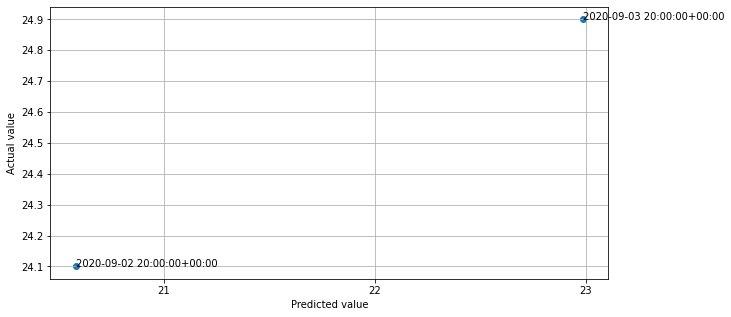

In [14]:
# 2.4 prepare data

# find predictions for days that we have actuals
x = []  # prediction
y = []  # actual
note = []
day_count = 0
for actual in actuals_query:
    if day_count > 1:
        break
    for prediction in noon_predictions:
        if actual.weather_date == prediction['prediction_timestamp']:
            day_count += 1
            note.append(actual.weather_date)
            x.append(prediction['tmp_tgl_2'][0])
            y.append(actual.temperature)

print('there are {} days with actuals that we have a model prediction for'.format(day_count))
# You should call .reshape() on x because this array is
# required to be two-dimensional, 
# or to be more precise, to have one column and as many rows as necessary.
x = np.array(x).reshape((-1, 1))
y = np.array(y)

# plot the data for sanity
fix, ax = plt.subplots(figsize=(10,5))

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.scatter(x, y)

for _x, _y, note in zip(x, y, note):
    ax.annotate(note, (_x, _y))

ax.grid(True)

plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.show()



In [15]:
# 3. create model and fit it

model = LinearRegression()

model.fit(x, y)

LinearRegression()

In [16]:
# 4. get results

r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 1.0
intercept: 17.251100561826473
slope: [0.33272829]


In [17]:
# 5. predict the response

x_pred = []
y_pred = []
for prediction in older_noon_predictions:
    # don't bother if we don't have an actual for that timestamp!
    if prediction['prediction_timestamp'] in actual_x:
        x_pred.append(prediction['prediction_timestamp'])
        y_pred.append(prediction['tmp_tgl_2'])

print(y_pred)
        
y_pred = model.predict(y_pred)
print(y_pred)

[array([25.59961829]), array([26.46577792]), array([22.19582187]), array([25.32299993]), array([27.12005454]), array([20.36168451]), array([17.13127445]), array([22.29764239]), array([17.66292152]), array([17.1594935]), array([21.33671016]), array([25.83257904]), array([28.93936925]), array([29.69386617]), array([27.28030529]), array([24.76661441]), array([20.1413191]), array([22.8968459]), array([18.68423764]), array([21.16978737]), array([18.29788655]), array([19.23337279]), array([20.34072194]), array([19.18806681]), array([23.2699125]), array([14.53175349]), array([15.73140954]), array([15.35016359]), array([23.20945188]), array([21.12146009]), array([23.72603069]), array([25.6438718]), array([24.76245562]), array([23.11136255]), array([16.91964675]), array([15.94341717]), array([21.34623021]), array([24.02362012]), array([24.54666372])]
[25.76881776 26.05701358 24.6362784  25.67677901 26.27470992 24.02600902
 22.95116021 24.67015697 23.12805422 22.96054948 24.35042764 25.8463304
 

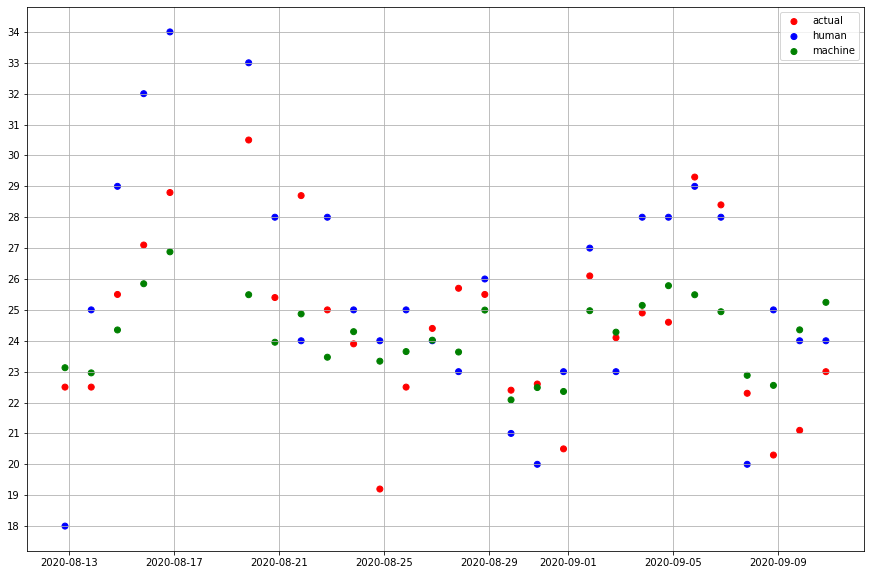

In [231]:
# 6. plot the results

fix, ax = plt.subplots(figsize=(15,10))

# we're only interested in days where we have an actual, a forecast, and a machine value

x_aa = []
y_aa = []
y_bb = []
y_cc = []

for x_a, y_a in zip(actual_x, actual_y):
    for x_b, y_b in zip(forecast_x, forecast_y):
        if x_a == x_b:
            for x_c, y_c in zip(x_pred, y_pred):
                if x_a == x_c:
                    x_aa.append(x_a)
                    y_aa.append(y_a)
                    y_bb.append(y_b)
                    y_cc.append(y_c)
                    


ax.yaxis.set_major_locator(MultipleLocator(1))
# ax.xaxis.set_major_locator(MultipleLocator(10))
ax.scatter(x_aa, y_aa, c=['r' for i in range(len(x_aa))], label='actual')
ax.scatter(x_aa, y_bb, c=['b' for i in range(len(x_aa))], label='human')
# ax.scatter(prediction_x, prediction_y, label='prediction')
ax.scatter(x_aa, y_cc, c=['g' for i in range(len(x_aa))], label='machine')

ax.legend()
ax.grid(True)

plt.show()

In [232]:
# let's evaluate. who's better - forecaster or the machine?

human_score = 0
machine_score = 0

for x, actual in zip(actual_x, actual_y):
    print('timestamp: {}'.format(x))
    print('actual: {}'.format(actual))
    machine_had_prediction = False
    human_had_forecast = False
    forecast_max_delta = 0
    forecast_min_delta = math.inf
    for x_axis, forecast in zip(forecast_x, forecast_y):
        if x_axis == x:
            human_had_forecast = True
            delta = abs(forecast-actual)
            forecast_max_delta = max(delta, forecast_max_delta)
            forecast_min_delta = min(delta, forecast_min_delta)
            print('forecast: {} (delta:{})'.format(forecast, delta))
    machine_max_delta = 0
    machine_min_delta = math.inf
    for x_axis, machine in zip(x_pred, y_pred):
        if x_axis == x:
            machine_had_prediction = True
            delta = abs(machine-actual)
            machine_max_delta = max(delta, machine_max_delta)
            machine_min_delta = min(delta, machine_min_delta)
            print('machine: {} (delta:{})'.format(machine, delta))
            
    # who go the closest?
    if machine_had_prediction and human_had_forecast:
        if forecast_min_delta < machine_min_delta:
            human_score += 1
            print('human wins for {}'.format(x))
        elif machine_min_delta < forecast_min_delta:
            machine_score += 1
            print('machine wins for {}'.format(x))
        else:
            print('it\'s a tie!')
        
#     if forecast_max_delta > 0 and machine_max_delta > 0:
#         if forecast_max_delta > machine_max_delta:
#             machine_score += 1
#             print('machine wins for {}'.format(x))
#         elif machine_max_delta > forecast_max_delta:
#             human_score += 1
#             print('human wins for {}'.format(x))
#         else:
#             print('it\'s a tie!')
        
print('machines: {} ; humans: {}'.format(machine_score, human_score))
if machine_score > human_score:
    print('the machines win the war')
elif human_score > machine_score:
    print('the humans win the war')
else:
    print('stalemate between the machines and the humans')

#     forecast = next(forecast for x_axis, forecast in zip(forecast_x, forecast_y) if x_axis == x)
#     print(forecast)

timestamp: 2020-09-02 20:00:00+00:00
actual: 24.1
forecast: 23.0 (delta:1.1000000000000014)
machine: 24.278807846068442 (delta:0.17880784606844102)
machine wins for 2020-09-02 20:00:00+00:00
timestamp: 2020-09-03 20:00:00+00:00
actual: 24.9
forecast: 28.0 (delta:3.1000000000000014)
machine: 25.14542216869608 (delta:0.2454221686960807)
machine wins for 2020-09-03 20:00:00+00:00
timestamp: 2020-09-04 20:00:00+00:00
actual: 24.6
forecast: 28.0 (delta:3.3999999999999986)
machine: 25.783542158577745 (delta:1.183542158577744)
machine wins for 2020-09-04 20:00:00+00:00
timestamp: 2020-09-05 20:00:00+00:00
actual: 29.3
forecast: 29.0 (delta:0.3000000000000007)
machine: 25.490270060568996 (delta:3.809729939431005)
human wins for 2020-09-05 20:00:00+00:00
timestamp: 2020-09-06 20:00:00+00:00
actual: 28.4
forecast: 28.0 (delta:0.3999999999999986)
machine: 24.94090468884276 (delta:3.4590953111572382)
human wins for 2020-09-06 20:00:00+00:00
timestamp: 2020-09-07 20:00:00+00:00
actual: 22.3
forecas

In [238]:
import csv

with open('machine.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date', 'actual_temperature', 'human_forecast', 'machine_prediction'])
    
    for row in zip(x_aa, y_aa, y_bb, y_cc):
#         print(row)
        writer.writerow(row)

